In [ ]:
# Install required libraries
!pip install torch torchvision opencv-python pillow numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import timm

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import json
import random
from tqdm import tqdm
import pickle
from PIL import Image
import warnings

import torchvision.transforms as transforms
from pathlib import Path

import kagglehub
from typing import List, Tuple, Optional

In [ ]:
def load_kaggle_ff_dataset():
    try:
        path = kagglehub.dataset_download("xdxd003/ff-c23")
        dataset_path = os.path.join(path, "FaceForensics++_C23")

        if os.path.exists(dataset_path):
            return dataset_path
        else:
            if os.path.exists(path):
                print(f"Using path: {path}")
                return path
            else:
                print("Dataset not found!")
                return None
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Load the dataset
dataset_path = load_kaggle_ff_dataset()

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/MyDrive/deepfake_detection'
os.makedirs(base_dir, exist_ok=True)
os.makedirs(f'{base_dir}/data', exist_ok=True)
os.makedirs(f'{base_dir}/models', exist_ok=True)
os.makedirs(f'{base_dir}/results', exist_ok=True)

In [ ]:
def print_dataset_structure(root_dir, indent=0):
    if not os.path.exists(root_dir):
        print("Dataset path does not exist!")
        return

    items = sorted(os.listdir(root_dir))
    for item in items:
        path = os.path.join(root_dir, item)
        prefix = "├── " if indent else ""
        print("    " * indent + prefix + item)

        # If it's a directory, recurse into it (but limit to first 5 entries inside)
        if os.path.isdir(path):
            sub_items = sorted(os.listdir(path))[:5]  # limit preview to 5 files/folders
            for sub_item in sub_items:
                sub_path = os.path.join(path, sub_item)
                sub_prefix = "├── " if indent else ""
                print("    " * (indent + 1) + sub_prefix + sub_item)
            if len(os.listdir(path)) > 5:
                print("    " * (indent + 1) + "└── ...")

print_dataset_structure(dataset_path)

DeepFakeDetection
    01_02__meeting_serious__YVGY8LOK.mp4
    01_02__outside_talking_still_laughing__YVGY8LOK.mp4
    01_02__talking_against_wall__YVGY8LOK.mp4
    01_02__walk_down_hall_angry__YVGY8LOK.mp4
    01_02__walking_down_indoor_hall_disgust__YVGY8LOK.mp4
    └── ...
Deepfakes
    000_003.mp4
    001_870.mp4
    002_006.mp4
    003_000.mp4
    004_982.mp4
    └── ...
Face2Face
    000_003.mp4
    001_870.mp4
    002_006.mp4
    003_000.mp4
    004_982.mp4
    └── ...
FaceShifter
    000_003.mp4
    001_870.mp4
    002_006.mp4
    003_000.mp4
    004_982.mp4
    └── ...
FaceSwap
    000_003.mp4
    001_870.mp4
    002_006.mp4
    003_000.mp4
    004_982.mp4
    └── ...
NeuralTextures
    000_003.mp4
    001_870.mp4
    002_006.mp4
    003_000.mp4
    004_982.mp4
    └── ...
csv
    DeepFakeDetection.csv
    Deepfakes.csv
    FF++_Metadata.csv
    FF++_Metadata_Shuffled.csv
    Face2Face.csv
    └── ...
original
    000.mp4
    001.mp4
    002.mp4
    003.mp4
    004.mp4
    └──

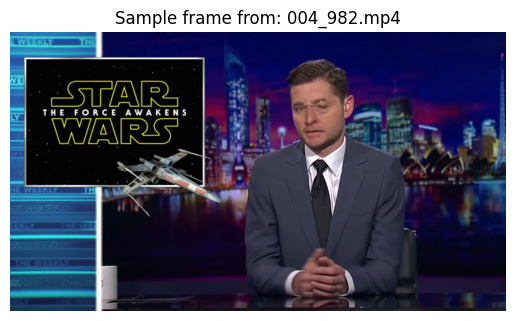

In [ ]:
def show_sample_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    success, frame = cap.read()
    if success:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        plt.title(f"Sample frame from: {os.path.basename(video_path)}")
        plt.axis('off')
        plt.show()
    else:
        print("Failed to read video.")
    cap.release()

# Example usage
sample_video = os.path.join(dataset_path, "FaceSwap", "004_982.mp4")
show_sample_frame(sample_video)

In [ ]:
def extract_frames_from_video(video_path, max_frames=10):
    frames = []
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return frames

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count == 0:
        cap.release()
        return frames

    step = max(1, frame_count // max_frames)
    frame_idx = 0

    # Load face cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    while cap.isOpened() and len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % step == 0:
            # Convert to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Detect faces
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)

            if len(faces) > 0:
                # Get the largest face
                largest_face = max(faces, key=lambda x: x[2] * x[3])
                x, y, w, h = largest_face

                # Add padding
                padding = 20
                x = max(0, x - padding)
                y = max(0, y - padding)
                w = min(frame.shape[1] - x, w + 2*padding)
                h = min(frame.shape[0] - y, h + 2*padding)

                # Crop face
                face_crop = frame_rgb[y:y+h, x:x+w]

                if face_crop.size > 0:
                    # Resize to standard size
                    face_resized = cv2.resize(face_crop, (224, 224))
                    frames.append(face_resized)

        frame_idx += 1

    cap.release()
    return frames

In [ ]:
def explore_kaggle_dataset(dataset_path):
    print("Dataset Structure:")

    # Check common folder names
    folders = ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'original']

    for folder in folders:
        folder_path = os.path.join(dataset_path, folder)
        if os.path.exists(folder_path):
            if folder == 'csv':
                files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
                print(f"{folder}/: {len(files)} CSV files")
                if files:
                    print(f"  CSV files: {files}")
            else:
                video_files = [f for f in os.listdir(folder_path)
                              if f.lower().endswith(('.mp4', '.avi', '.mov'))]
                print(f"{folder}/: {len(video_files)} videos")
                if video_files:
                    print(f"  Sample files: {video_files[:3]}...")
        else:
            print(f"{folder}/: NOT FOUND")

    # Also check what's actually in the dataset path
    print(f"\nActual contents of {dataset_path}:")
    try:
        actual_contents = os.listdir(dataset_path)
        for item in actual_contents:
            item_path = os.path.join(dataset_path, item)
            if os.path.isdir(item_path):
                sub_items = os.listdir(item_path)
                print(f"{item}/: {len(sub_items)} items")
                if len(sub_items) <= 10:
                    print(f"  Contents: {sub_items}")
                else:
                    print(f"  Sample contents: {sub_items[:5]}...")
            else:
                print(f"{item} (file)")
    except Exception as e:
        print(f"Error reading directory: {e}")

# Explore the dataset
if dataset_path:
    explore_kaggle_dataset(dataset_path)
else:
    print("Cannot explore dataset - path not found")

Dataset Structure:
DeepFakeDetection/: 1000 videos
  Sample files: ['02_09__kitchen_pan__9TDCEK1Q.mp4', '02_13__exit_phone_room__CP5HFV3K.mp4', '24_10__walking_down_street_outside_angry__356HPS7R.mp4']...
Deepfakes/: 1000 videos
  Sample files: ['479_706.mp4', '481_469.mp4', '184_205.mp4']...
Face2Face/: 1000 videos
  Sample files: ['479_706.mp4', '481_469.mp4', '184_205.mp4']...
FaceShifter/: 1000 videos
  Sample files: ['479_706.mp4', '481_469.mp4', '184_205.mp4']...
FaceSwap/: 1000 videos
  Sample files: ['479_706.mp4', '481_469.mp4', '184_205.mp4']...
NeuralTextures/: 1000 videos
  Sample files: ['479_706.mp4', '481_469.mp4', '184_205.mp4']...
original/: 1000 videos
  Sample files: ['123.mp4', '738.mp4', '479.mp4']...

Actual contents of /kaggle/input/ff-c23/FaceForensics++_C23:
Face2Face/: 1000 items
  Sample contents: ['479_706.mp4', '481_469.mp4', '184_205.mp4', '315_322.mp4', '645_688.mp4']...
csv/: 10 items
  Contents: ['FaceSwap.csv', 'FaceShifter.csv', 'DeepFakeDetection.csv

In [ ]:
def create_balanced_dataset(dataset_path, samples_per_class=500, max_frames_per_video=5):
    print(f"Creating balanced dataset with {samples_per_class} samples per class...")

    frame_paths = []
    labels = []
    output_dir = os.path.join(base_dir, 'data', 'frames')
    os.makedirs(output_dir, exist_ok=True)

    real_count = 0
    fake_count = 0

    # Define known deepfake method folders
    DEEPFAKE_METHODS = ['Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures']

    # Check actual folder structure
    actual_folders = os.listdir(dataset_path)
    print(f"Available folders: {actual_folders}")

    # Process real videos (original folder)
    original_folders = ['original']
    for folder in actual_folders:
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            if 'original' in folder.lower() or 'real' in folder.lower():
                original_folders.append(folder)
            else:
                # Check if it's a parent folder containing original videos
                sub_folders = os.listdir(folder_path)
                if any('original' in sub.lower() or 'real' in sub.lower() for sub in sub_folders):
                    original_folders.extend([os.path.join(folder, sub) for sub in sub_folders
                                           if 'original' in sub.lower() or 'real' in sub.lower()])

    print(f"Original folders found: {original_folders}")

    # Process original videos
    for orig_folder in original_folders:
        if real_count >= samples_per_class:
            break

        folder_path = os.path.join(dataset_path, orig_folder)
        if os.path.exists(folder_path):
            video_files = [f for f in os.listdir(folder_path)
                          if f.lower().endswith(('.mp4', '.avi', '.mov'))]

            for video_file in tqdm(video_files, desc=f"Processing real videos from {orig_folder}"):
                if real_count >= samples_per_class:
                    break

                video_path = os.path.join(folder_path, video_file)
                frames = extract_frames_from_video(video_path, max_frames_per_video)

                for i, frame in enumerate(frames):
                    if real_count >= samples_per_class:
                        break

                    frame_path = os.path.join(output_dir, f'real_{real_count}_{video_file}_{i}.jpg')

                    # Save frame
                    frame_pil = Image.fromarray(frame)
                    frame_pil.save(frame_path)

                    frame_paths.append(frame_path)
                    labels.append(0)  # 0 for real
                    real_count += 1

    # Process fake videos from all deepfake methods
    for method in DEEPFAKE_METHODS:
        if fake_count >= samples_per_class:
            break

        # Check if method exists in dataset
        method_folders = [f for f in actual_folders if method.lower() in f.lower()]

        for method_folder in method_folders:
            if fake_count >= samples_per_class:
                break

            folder_path = os.path.join(dataset_path, method_folder)
            if os.path.exists(folder_path):
                video_files = [f for f in os.listdir(folder_path)
                             if f.lower().endswith(('.mp4', '.avi', '.mov'))]

                videos_to_process = video_files[:200]

                for video_file in tqdm(videos_to_process, desc=f"Processing {method} videos"):
                    if fake_count >= samples_per_class:
                        break

                    video_path = os.path.join(folder_path, video_file)
                    frames = extract_frames_from_video(video_path, max_frames_per_video)

                    for i, frame in enumerate(frames):
                        if fake_count >= samples_per_class:
                            break

                        frame_path = os.path.join(output_dir, f'fake_{fake_count}_{method}_{video_file}_{i}.jpg')

                        # Save frame
                        frame_pil = Image.fromarray(frame)
                        frame_pil.save(frame_path)

                        frame_paths.append(frame_path)
                        labels.append(1)  # 1 for fake
                        fake_count += 1

    print(f"Dataset created: {real_count} real + {fake_count} fake = {len(frame_paths)} total")

    # Shuffle data
    combined = list(zip(frame_paths, labels))
    random.shuffle(combined)
    frame_paths, labels = zip(*combined)

    return list(frame_paths), list(labels)

if dataset_path:
    print("Creating balanced dataset...")
    frame_paths, labels = create_balanced_dataset(dataset_path, samples_per_class=2000)
else:
    print("Cannot create dataset - dataset path not found")

Creating balanced dataset...
Creating balanced dataset with 2000 samples per class...
Available folders: ['Face2Face', 'csv', 'Deepfakes', 'DeepFakeDetection', 'original', 'NeuralTextures', 'FaceShifter', 'FaceSwap']
Original folders found: ['original', 'csv/original.csv', 'original']


Processing FaceShifter videos:   1%|          | 2/200 [00:18<30:07,  9.13s/it]

Dataset created: 2000 real + 2000 fake = 4000 total


In [ ]:
def get_transforms(mode='train'):
    if mode == 'train':
        transform = A.Compose([
            A.Resize(256, 256),
            A.RandomCrop(224, 224),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Rotate(limit=15, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
            A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.2),  # Simulate compression artifacts
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    elif mode == 'val':
        transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    else:  # test
        transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    return transform

In [ ]:
class DeepFakeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.cache = {}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]

        try:
            image_path = self.image_paths[idx]
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Failed to read image at {image_path}")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            label = self.labels[idx]

            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']

            # Cache the processed image
            self.cache[idx] = (image, label)
            return image, label

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a random image if there's an error
            random_idx = random.randint(0, len(self)-1)
            return self[random_idx]

In [ ]:
def create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32):
    train_transform = get_transforms('train')
    val_transform = get_transforms('val')
    test_transform = get_transforms('test')

    # Create datasets
    train_dataset = DeepFakeDataset(X_train, y_train, train_transform)
    val_dataset = DeepFakeDataset(X_val, y_val, val_transform)
    test_dataset = DeepFakeDataset(X_test, y_test, test_transform)

    # Determine optimal number of workers
    num_cpus = os.cpu_count() or 1
    train_workers = min(4, num_cpus - 1) if num_cpus > 1 else 0
    val_workers = min(2, num_cpus - 1) if num_cpus > 1 else 0

    # Windows compatibility
    if os.name == 'nt':
        train_workers = 0
        val_workers = 0

    # Create data loaders
    loaders = []
    for dataset, workers, shuffle in zip(
        [train_dataset, val_dataset, test_dataset],
        [train_workers, val_workers, val_workers],
        [True, False, False]
    ):
        loader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=workers,
            pin_memory=True,
            persistent_workers=workers > 0,
            drop_last=shuffle
        )
        loaders.append(loader)

    return tuple(loaders)

if len(frame_paths) > 0:
    try:
        # Clear memory before loading
        import torch
        torch.cuda.empty_cache()
        import gc
        gc.collect()

        # Split data with stratification
        X_train, X_test, y_train, y_test = train_test_split(
            frame_paths, labels,
            test_size=0.2,
            random_state=42,
            stratify=labels
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42,
            stratify=y_train
        )

        # Create loaders with error handling
        train_loader, val_loader, test_loader = create_data_loaders(
            X_train, y_train,
            X_val, y_val,
            X_test, y_test,
            batch_size=32
        )

        # Verify the first batch loads correctly
        try:
            sample_batch, sample_labels = next(iter(train_loader))
            print("\nData pipeline successfully created:")
            print(f"Training samples: {len(train_loader.dataset)}")
            print(f"Validation samples: {len(val_loader.dataset)}")
            print(f"Test samples: {len(test_loader.dataset)}")
            print(f"\nSample batch shape: {sample_batch.shape}")
            print(f"Sample labels: {sample_labels[:10]}")  # Show first 10 labels

            assert sample_batch.shape[0] == 32
            assert sample_labels.shape[0] == 32

        except Exception as e:
            print(f"Error in first batch loading: {str(e)}")
            print("Trying fallback with num_workers=0...")

            # Fallback to single-process loading
            train_loader = DataLoader(
                train_dataset,
                batch_size=32,
                shuffle=True,
                num_workers=0
            )
            sample_batch, sample_labels = next(iter(train_loader))
            print("Fallback successful - using num_workers=0")

    except Exception as e:
        print(f"An error occurred during data loading or splitting: {e}")
        print("Check dataset_path, frame_paths, and labels.")

else:
    print("Error: No data available to create datasets")
    print("Check your frame_paths and labels variables")

/tmp/ipython-input-219596595.py:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
/tmp/ipython-input-219596595.py:11: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.2),  # Simulate compression artifacts



Data pipeline successfully created:
Training samples: 2880
Validation samples: 320
Test samples: 800

Sample batch shape: torch.Size([32, 3, 224, 224])
Sample labels: tensor([1, 0, 0, 1, 1, 0, 1, 1, 0, 0])


In [ ]:
class DeepfakeDetector(nn.Module):
    def __init__(self, model_name, num_classes=2, pretrained=True):
        super(DeepfakeDetector, self).__init__()

        # Load pre-trained model
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)

        # Get feature dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 380, 380)
            features = self.backbone(dummy_input)
            feature_dim = features.shape[1]

        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output

# Define the device before creating the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = DeepfakeDetector('efficientnet_b4', num_classes=2, pretrained=True)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Model created successfully!
Total parameters: 18,467,658
Trainable parameters: 18,467,658


In [ ]:
def train_model(model, train_loader, val_loader, device, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc='Training'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc='Validation'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct_val / total_val

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step()
        print()

    return train_losses, val_losses, train_accs, val_accs, optimizer

In [ ]:
def save_model(model, optimizer, epoch, save_path):

  if os.path.exists(save_path):
    os.remove(save_path)
    print(f"Existing model at {save_path} deleted.")

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, save_path)
    print(f"Model checkpoint saved to {save_path}")

In [ ]:
    # Train the model. This will return the trained optimizer
    print("Starting training process with dummy data...")
    num_epochs = 10
    train_losses, val_losses, train_accs, val_accs, final_optimizer = train_model(
        model, train_loader, val_loader, device, num_epochs=num_epochs
    )
    print("Training complete.")

    # Define the path to save the model checkpoint
    save_dir = '/content/drive/My Drive/deepfake_detection/models/'
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, 'efficientnet_b4_checkpoint.pth')

    # Save the model using the returned optimizer and the last epoch number
    save_model(model, final_optimizer, num_epochs, save_path)

Starting training process with dummy data...
Epoch 1/10
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.01it/s]


Train Loss: 0.5788, Train Acc: 66.08%
Val Loss: 0.2992, Val Acc: 87.50%

Epoch 2/10
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.57it/s]


Train Loss: 0.3160, Train Acc: 83.54%
Val Loss: 0.3745, Val Acc: 86.56%

Epoch 3/10
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.87it/s]


Train Loss: 0.2257, Train Acc: 89.34%
Val Loss: 0.3608, Val Acc: 90.94%

Epoch 4/10
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


Train Loss: 0.2026, Train Acc: 91.11%
Val Loss: 1.1796, Val Acc: 74.38%

Epoch 5/10
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


Train Loss: 0.1498, Train Acc: 94.03%
Val Loss: 0.1878, Val Acc: 91.88%

Epoch 6/10
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


Train Loss: 0.1157, Train Acc: 95.21%
Val Loss: 0.4103, Val Acc: 86.56%

Epoch 7/10
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


Train Loss: 0.0981, Train Acc: 96.39%
Val Loss: 0.1755, Val Acc: 94.06%

Epoch 8/10
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


Train Loss: 0.0607, Train Acc: 97.78%
Val Loss: 0.1604, Val Acc: 94.38%

Epoch 9/10
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Train Loss: 0.0217, Train Acc: 99.34%
Val Loss: 0.1668, Val Acc: 94.69%

Epoch 10/10
----------


Validation: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Train Loss: 0.0094, Train Acc: 99.83%
Val Loss: 0.1705, Val Acc: 94.38%

Training complete.
Existing model at /content/drive/My Drive/deepfake_detection/models/efficientnet_b4_checkpoint.pth deleted.
Model checkpoint saved to /content/drive/My Drive/deepfake_detection/models/efficientnet_b4_checkpoint.pth


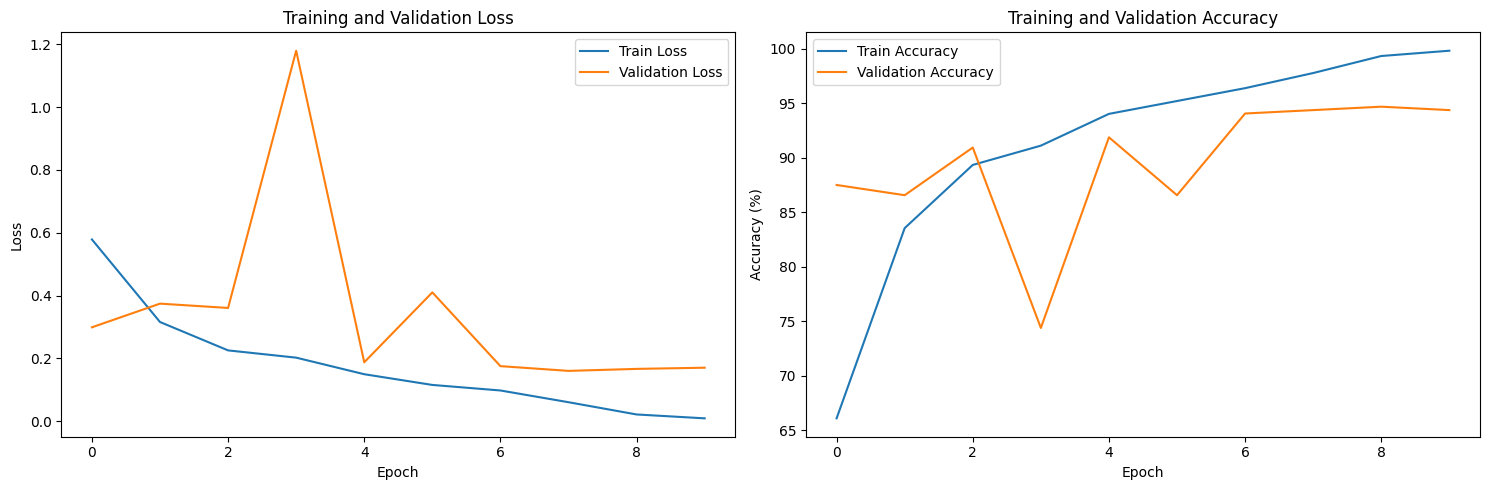

In [ ]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracies
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot the results
if 'train_losses' in locals():
    plot_training_history(train_losses, val_losses, train_accs, val_accs)
else:
    print("No training history to plot")

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {accuracy:.4f}')

    # Classification report
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy, all_preds, all_labels

Testing: 100%|██████████| 25/25 [00:04<00:00,  5.17it/s]


Test Accuracy: 0.9337

Classification Report:
              precision    recall  f1-score   support

        Real       0.92      0.95      0.93       400
        Fake       0.95      0.92      0.93       400

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800



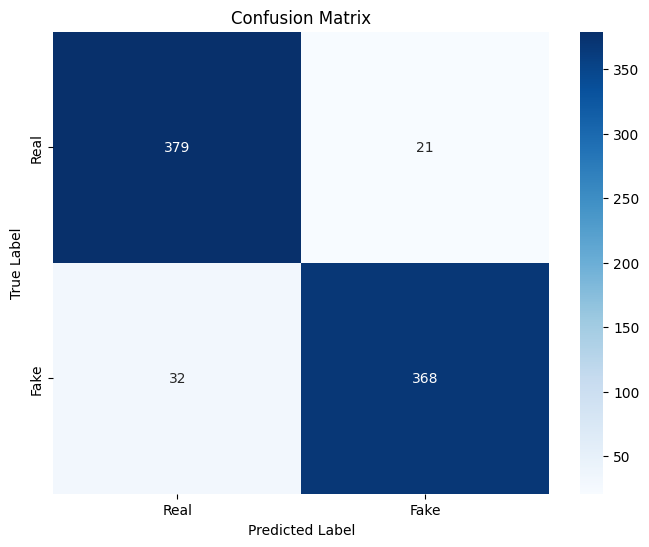

In [ ]:
if 'model' in locals() and len(frame_paths) > 0:
    try:
        test_accuracy, predictions, true_labels = evaluate_model(model, test_loader)

    except FileNotFoundError:
        print("Best model not found. Using current model state.")
        test_accuracy, predictions, true_labels = evaluate_model(model, test_loader)

else:
    print("Cannot evaluate - model or data not available")

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 3.4 MB/

In [ ]:
class DeepfakeDetector(nn.Module):
    def __init__(self, model_name, num_classes=2, pretrained=True):
        super(DeepfakeDetector, self).__init__()
        # Load pre-trained backbone
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)

        # Get feature dimension from the backbone's output
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 380, 380)
            features = self.backbone(dummy_input)
            feature_dim = features.shape[1]

        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output

# Define the device and model paths
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/content/drive/My Drive/deepfake_detection/models/efficientnet_b4_checkpoint.pth'

# Instantiate and load the model
try:
    model = DeepfakeDetector('efficientnet_b4', num_classes=2, pretrained=False)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    model = model.to(device)
    print("Model loaded successfully!")
except FileNotFoundError:
    print(f"Error: Model checkpoint not found at {model_path}. Please check the path.")
    exit()

Model loaded successfully!


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def extract_frames_from_video(video_path, max_frames=10):
    frames = []
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return frames

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count == 0:
        cap.release()
        return frames

    step = max(1, frame_count // max_frames)
    frame_idx = 0

    # Load face cascade classifier
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    while cap.isOpened() and len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % step == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            faces = face_cascade.detectMultiScale(gray, 1.1, 4)

            if len(faces) > 0:
                largest_face = max(faces, key=lambda x: x[2] * x[3])
                x, y, w, h = largest_face

                padding = 20
                x = max(0, x - padding)
                y = max(0, y - padding)
                w = min(frame.shape[1] - x, w + 2*padding)
                h = min(frame.shape[0] - y, h + 2*padding)

                face_crop = frame_rgb[y:y+h, x:x+w]

                if face_crop.size > 0:
                    frames.append(face_crop)

        frame_idx += 1

    cap.release()
    return frames

Extracting frames from /kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes/479_706.mp4...
Extracted 10 frames.


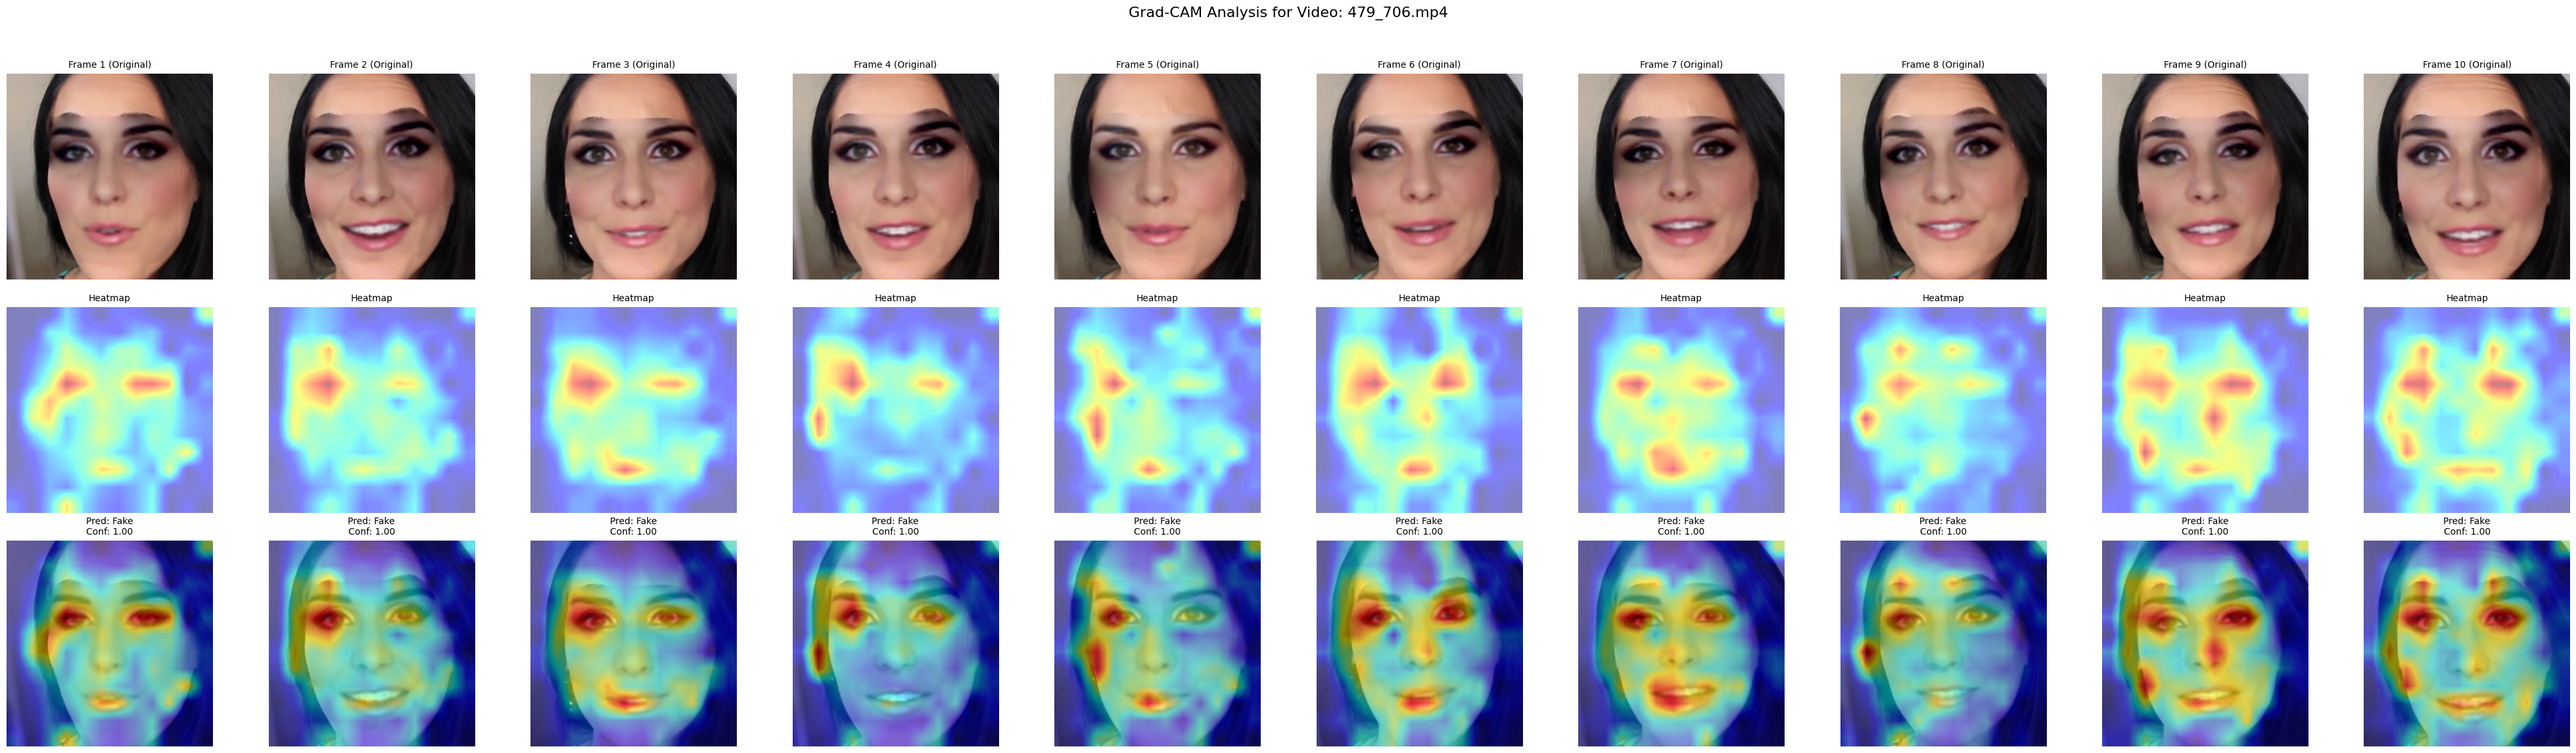

In [ ]:
def visualize_grad_cam_for_video(video_path, model, device, output_dir='grad_cam_output'):
    os.makedirs(output_dir, exist_ok=True)

    # Define the image transformations
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((380, 380)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Extract cropped face frames from the video
    print(f"Extracting frames from {video_path}...")
    frames = extract_frames_from_video(video_path, max_frames=10)
    print(f"Extracted {len(frames)} frames.")

    if not frames:
        print("No frames with faces were extracted. Cannot perform Grad-CAM.")
        return

    # Define the target layer for Grad-CAM
    target_layers = [model.backbone.conv_head]
    cam = GradCAM(model=model, target_layers=target_layers)

    # Setup the plot for all frames
    fig, axes = plt.subplots(3, len(frames), figsize=(4 * len(frames), 12))
    fig.suptitle(f"Grad-CAM Analysis for Video: {os.path.basename(video_path)}", fontsize=16)

    # Process each frame
    for i, frame in enumerate(frames):
        # Convert the frame to a PIL Image and resize it for consistent input
        original_image = Image.fromarray(frame)
        resized_image = original_image.resize((380, 380), Image.Resampling.LANCZOS)

        # Convert the resized image to a tensor for the model
        input_tensor = transform(np.array(resized_image)).unsqueeze(0).to(device)

        # Get model predictions and confidence
        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.softmax(output, dim=1)
            confidence, predicted_class = torch.max(probabilities, 1)

        targets = [ClassifierOutputTarget(predicted_class.item())]

        # Generate the heatmap
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        # Get the resized image as a NumPy array for visualization
        rgb_img = np.float32(np.array(resized_image)) / 255

        # Overlay the heatmap on the resized image
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # Plotting the images in a single row
        # Original Frame
        axes[0, i].imshow(resized_image)
        axes[0, i].set_title(f"Frame {i+1} (Original)", fontsize=10)
        axes[0, i].axis('off')

        # Heatmap
        axes[1, i].imshow(grayscale_cam, cmap='jet', alpha=0.5)
        axes[1, i].set_title(f"Heatmap", fontsize=10)
        axes[1, i].axis('off')

        # Overlay with Confidence
        axes[2, i].imshow(visualization)
        prediction_label = "Fake" if predicted_class.item() == 1 else "Real"
        axes[2, i].set_title(f"Pred: {prediction_label}\nConf: {confidence.item():.2f}", fontsize=10)
        axes[2, i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

try:

    sample_video = os.path.join(dataset_path, "Deepfakes", "479_706.mp4")
    visualize_grad_cam_for_video(sample_video, model, device)
except Exception as e:
    print(f"An error occurred during video processing: {e}")

Extracting frames from /kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes/479_706.mp4...
Extracted 10 frames.


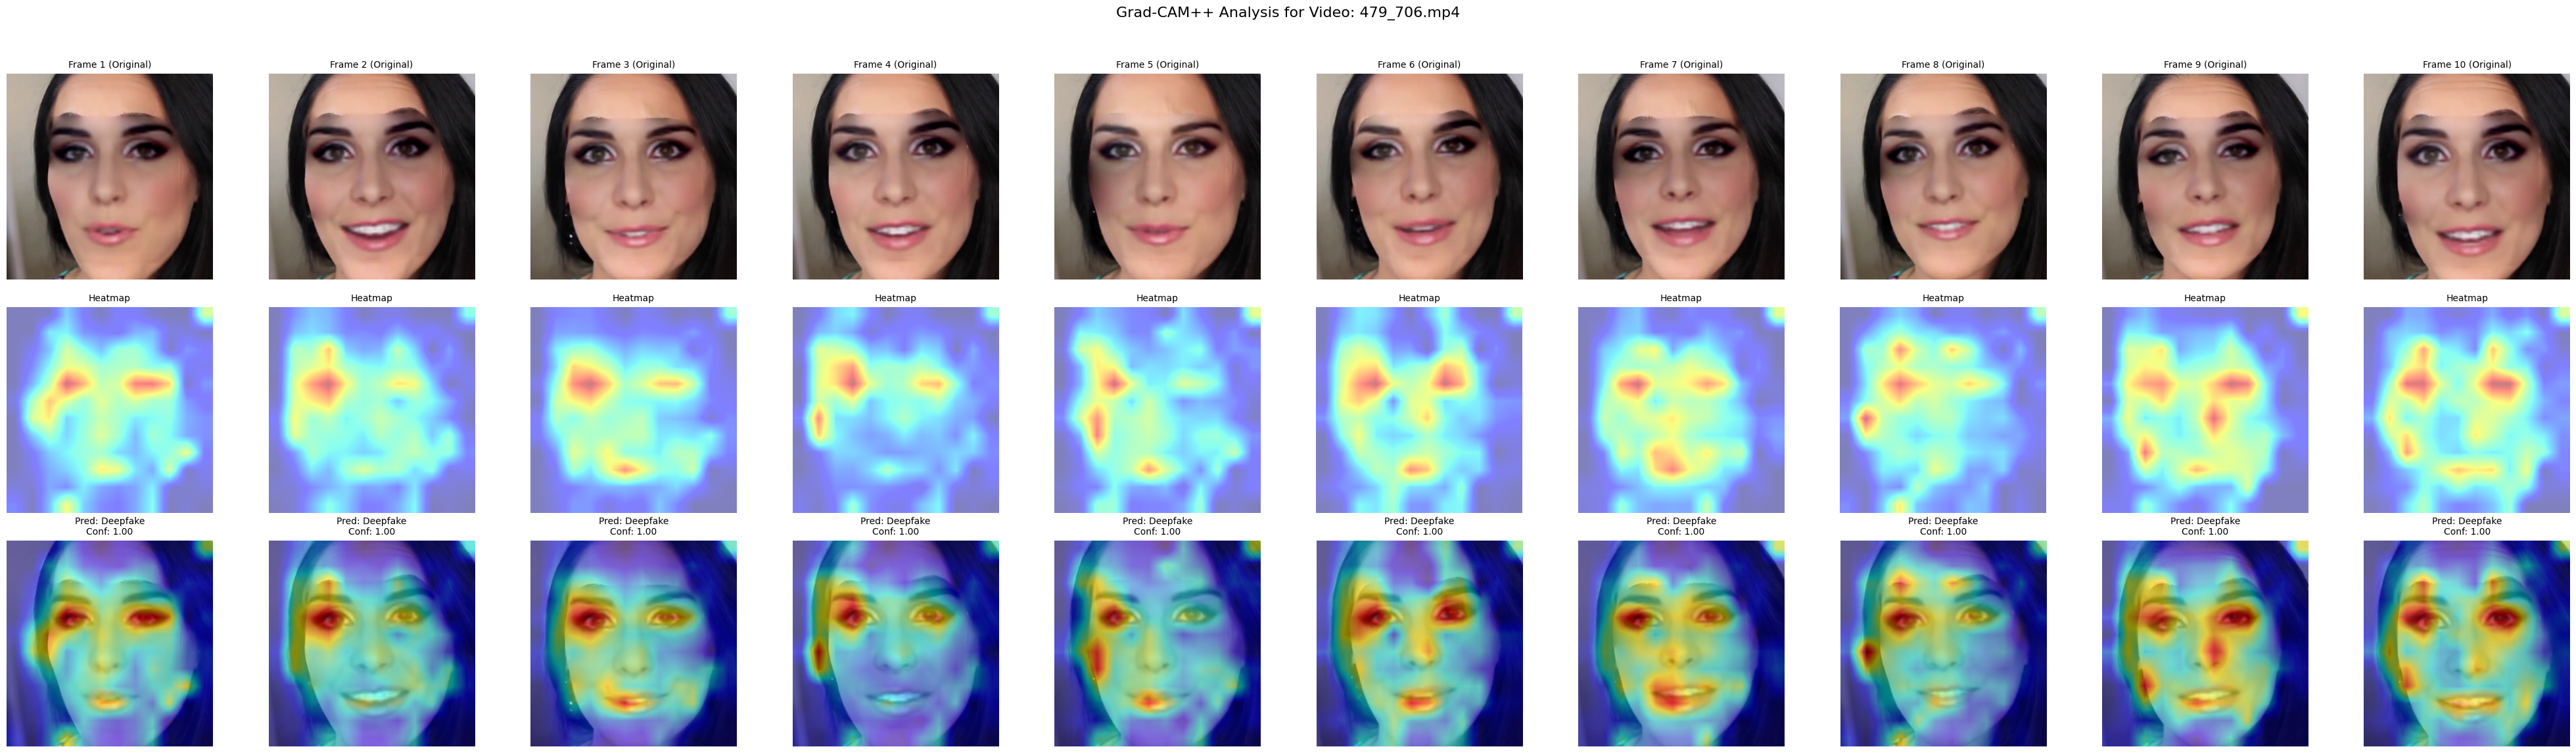

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_grad_cam_plus_plus_for_video(video_path, model, device, output_dir='grad_cam_output'):
    os.makedirs(output_dir, exist_ok=True)

    # Define the image transformations
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((380, 380)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Extract cropped face frames from the video
    print(f"Extracting frames from {video_path}...")
    frames = extract_frames_from_video(video_path, max_frames=10)
    print(f"Extracted {len(frames)} frames.")

    if not frames:
        print("No frames with faces were extracted. Cannot perform Grad-CAM.")
        return

    # Define the target layer for Grad-CAM++
    target_layers = [model.backbone.conv_head]
    cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

    # Set the target class for visualization (e.g., deepfake = 1)
    targets = [ClassifierOutputTarget(1)]

    # Setup the plot for all frames
    fig, axes = plt.subplots(3, len(frames), figsize=(4 * len(frames), 12))
    fig.suptitle(f"Grad-CAM++ Analysis for Video: {os.path.basename(video_path)}", fontsize=16)

    # Process each frame
    for i, frame in enumerate(frames):
        # Convert the frame to a PIL Image and resize it for consistent input
        original_image = Image.fromarray(frame)
        resized_image = original_image.resize((380, 380), Image.Resampling.LANCZOS)

        # Convert the resized image to a tensor for the model
        input_tensor = transform(np.array(resized_image)).unsqueeze(0).to(device)

        # Get model predictions and confidence
        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.softmax(output, dim=1)
            confidence, predicted_class = torch.max(probabilities, 1)

        # Generate the heatmap
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        # Get the resized image as a NumPy array for visualization
        rgb_img = np.float32(np.array(resized_image)) / 255

        # Overlay the heatmap on the resized image
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # Plotting the images in a single row
        # Original Frame
        if len(frames) > 1:
            axes[0, i].imshow(resized_image)
            axes[0, i].set_title(f"Frame {i+1} (Original)", fontsize=10)
            axes[0, i].axis('off')

            # Heatmap
            axes[1, i].imshow(grayscale_cam, cmap='jet', alpha=0.5)
            axes[1, i].set_title(f"Heatmap", fontsize=10)
            axes[1, i].axis('off')

            # Overlay with Confidence
            axes[2, i].imshow(visualization)
            prediction_label = "Deepfake" if predicted_class.item() == 1 else "Real"
            axes[2, i].set_title(f"Pred: {prediction_label}\nConf: {confidence.item():.2f}", fontsize=10)
            axes[2, i].axis('off')
        else: # Handle single frame case
            axes[0].imshow(resized_image)
            axes[0].set_title(f"Frame {i+1} (Original)", fontsize=10)
            axes[0].axis('off')

            axes[1].imshow(grayscale_cam, cmap='jet', alpha=0.5)
            axes[1].set_title(f"Heatmap", fontsize=10)
            axes[1].axis('off')

            axes[2].imshow(visualization)
            prediction_label = "Deepfake" if predicted_class.item() == 1 else "Real"
            axes[2].set_title(f"Pred: {prediction_label}\nConf: {confidence.item():.2f}", fontsize=10)
            axes[2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

try:

    sample_video = os.path.join(dataset_path, "Deepfakes", "479_706.mp4")
    visualize_grad_cam_plus_plus_for_video(sample_video, model, device)
except Exception as e:
    print(f"An error occurred during video processing: {e}")